In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import scipy.stats as stats
import networkx as nx
import re
import os
import pickle
import requests
import json
import urllib.request
from fa2 import ForceAtlas2
import community

In [50]:
# create two functions that clean the names and links

def parse_links_from_file(file):
    links = set()
    for link in re.findall('\[\[([^\]]*)\]\]', file):
        if '|' in link:
            link = link.split('|')[0]
        links.add(link)
    return [link.lower() for link in links]

def parse_node(node):
    return node.split(".")[0].replace("_", " ").replace(" dc", "").replace(" marvel", "").lower()

In [51]:
# go through the txt files in os_listdir() and create a node with the name of the file and add an attribute if they are from dc or marvel and open the file and find the hyperlinks in the file and if the hyperlinks has any word that is a node in the graph add an edge between the node and the hyperlinks. if the hyperlinks has a word that is not a node in the graph skip it. If there is an edge already skip it
G = nx.DiGraph()

for i in os.listdir():
    if i.endswith(".txt"):
        with open(i, 'r') as f:
            file = f.read()
            if "dc" in i:
                G.add_node(parse_node(i), type='dc', file=i, words = len(re.findall(r'\w+', file)))
            else:
                G.add_node(parse_node(i), type='marvel', file=i, words = len(re.findall(r'\w+', file)))

In [52]:
edges = {}

for i in G.nodes(data=True):
    with open(i[1]['file'], 'r') as f:
        file = f.read()
        links = parse_links_from_file(file)
        edges[i[0]] = links

for name, edges in edges.items():
    for edge in edges:
        if edge in list(G.nodes):
            G.add_edge(*(name, edge))

In [53]:
# info about the graph

print(nx.info(G))



DiGraph with 1231 nodes and 9706 edges


In [54]:
#extract the largest component from the graph

G1 = max(nx.weakly_connected_components(G), key=len)

G1 = G.subgraph(G1)

# print number of links and nodes in the graph 

print(nx.info(G1))




DiGraph with 1095 nodes and 9705 edges


In [56]:
#convert our network to undirected graph 

G1 = G1.to_undirected()

# print number of links and nodes in the graph

print(nx.info(G1))

Graph with 1095 nodes and 8159 edges


In [57]:
from networkx import draw_kamada_kawai

In [58]:
#Use the NetworkX command nx.draw_kamada_kawai to draw the network

colormap = []
for i in G1.nodes(data=True):
    if i[1]['type'] == 'dc':
        colormap.append('red')
    else:
        colormap.append('blue')

# add color to the edges 

edge_color = []
for i in G1.edges(data=True):
    if G1.nodes[i[0]]['type'] == 'dc' and G1.nodes[i[1]]['type'] == 'dc':
        edge_color.append('red')
    elif G1.nodes[i[0]]['type'] == 'marvel' and G1.nodes[i[1]]['type'] == 'marvel':
        edge_color.append('blue')
    else:
        edge_color.append('yellow')


node_size = [G1.degree(i) * 100 for i in G1.nodes()] 







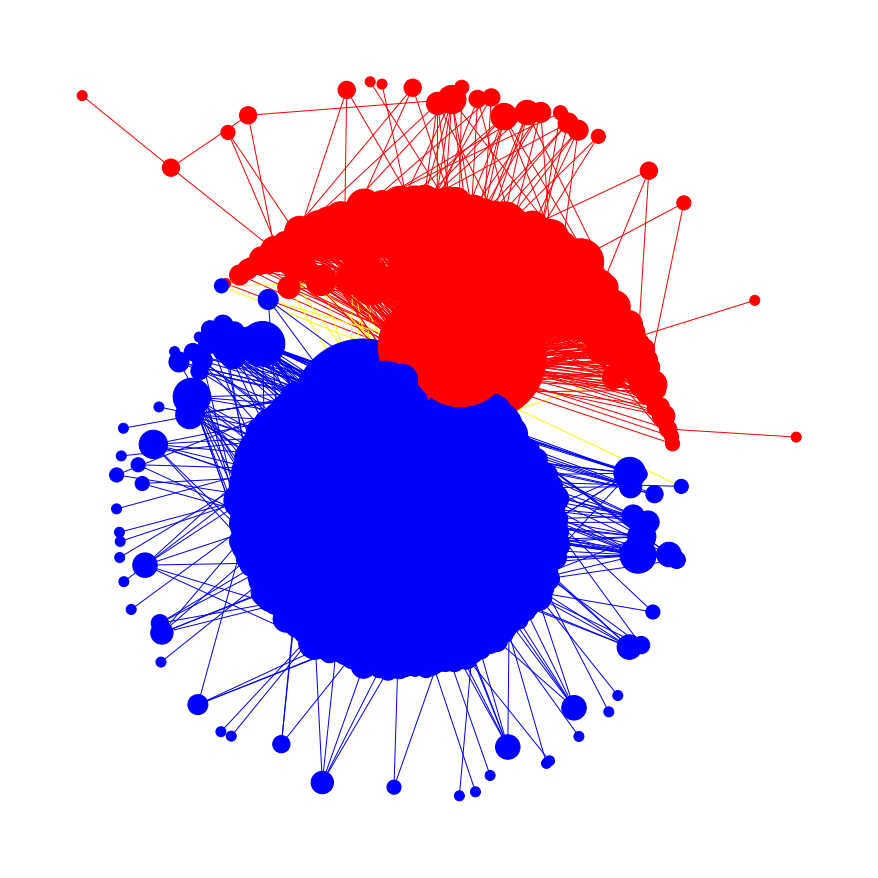

In [59]:
# draw the graph

plt.figure(figsize=(12,12))
draw_kamada_kawai(G1, node_color=colormap, edge_color=edge_color, with_labels=False, node_size=node_size)
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.87it/s]


BarnesHut Approximation  took  6.26  seconds
Repulsion forces  took  23.55  seconds
Gravitational forces  took  0.14  seconds
Attraction forces  took  0.25  seconds
AdjustSpeedAndApplyForces step  took  0.53  seconds


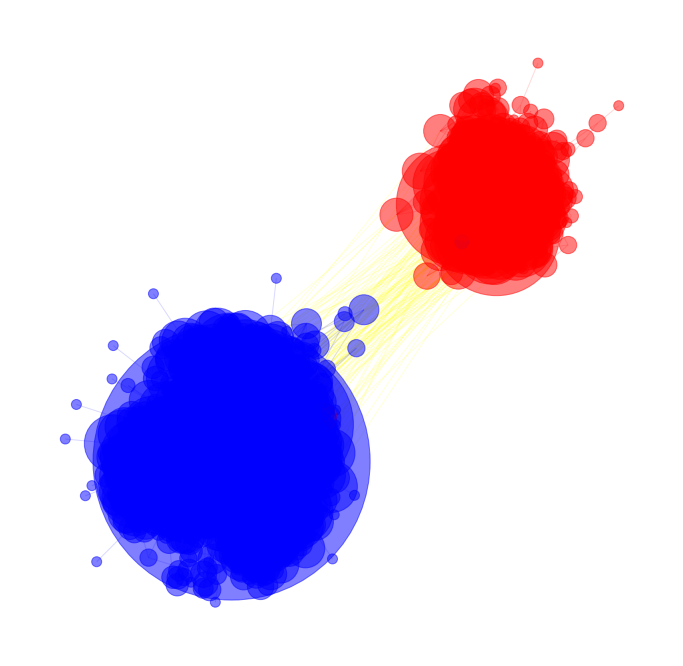

In [60]:
# draw the graph with force atlas 2 

forceatlas2 = ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,  # Dissuade hubs
                            linLogMode=False,  # NOT IMPLEMENTED
                            adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                            edgeWeightInfluence=1.0,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=2.0,

                            # Log
                            verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G1, pos=None, iterations=2000)

plt.figure(figsize=(12,12))
#nx.draw_networkx(G1, pos=positions, node_color=colormap, edge_color=edge_color, with_labels=False, node_size=node_size)
#plt.show()

nx.draw_networkx_nodes(G1, positions, node_size=node_size, node_color=colormap, alpha=0.5)
nx.draw_networkx_edges(G1, positions, edge_color=edge_color, alpha=0.15)
plt.axis('off')
plt.show()






In [45]:
comms = community.best_partition(G1)

In [48]:
comms_values = list(comms.values())

size_communities = float(len(set(comms_values)))
print(size_communities)

7.0


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:35<00:00, 56.51it/s]


BarnesHut Approximation  took  5.86  seconds
Repulsion forces  took  28.13  seconds
Gravitational forces  took  0.12  seconds
Attraction forces  took  0.21  seconds
AdjustSpeedAndApplyForces step  took  0.49  seconds


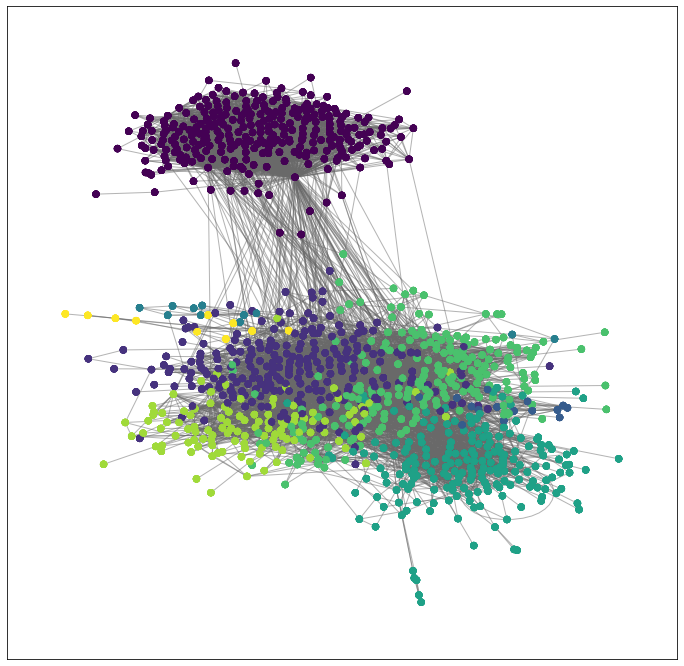

In [42]:
plt.figure(figsize=(12,12))
size = float(len(set(comms.values())))
pos = forceatlas2.forceatlas2_networkx_layout(G1, pos=None, iterations=2000)
count = 0.
cmap = cm.get_cmap('viridis', max(comms.values()) + 1)
for com in set(comms.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in comms.keys()
                                if comms[nodes] == com]
    nx.draw_networkx_nodes(G1, pos, comms.keys(), node_size=40,
                     cmap=cmap, node_color=list(comms.values()))


communities=nx.draw_networkx_edges(G1, pos, alpha=0.5, edge_color="dimgray")

plt.show()

In [31]:
community.modularity(comms, G1)

0.5468087948647139

AttributeError: 'dict' object has no attribute 'is_directed'

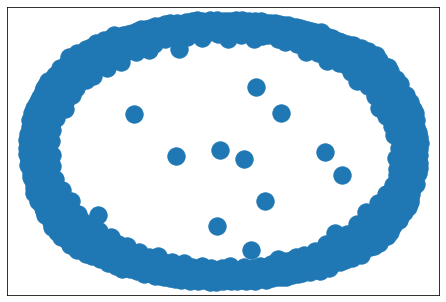